# Which Features to explain?
The objective of this notebook is to mechanically hand-pick features when show-casing the coefficients from the Lasso model. <br>
I'll be using LGBM as it can handle missing values by allocating them to side(during splits) that reduces loss. <br>
Therefore, the Data processing is a little different as I will change all the unknowns to np.nan. <br>

### Libraries to import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy import stats
%matplotlib inline
import random
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

### Import Data:
I have hand selected 79 columns from the original 240. <br>In addition, I will take a random sample of 750,000 for the sake of this project.

In [2]:
columns = ['dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'mager', 'mbstate_rec', 'restatus', 'mrace6', 'mhisp_r', 'mracehisp', 'dmar', 'meduc', 'fagecomb',
          'frace6', 'fhisp_r', 'fracehisp', 'feduc', 'priorlive', 'priordead', 'priorterm', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'cig_0',
          'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'f_m_ht', 'bmi', 'pwgt_r', 'dwgt_r', 'wtgain', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
          'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesar', 'rf_cesarn', 'no_risks', 'ip_gon', 'ip_syph', 'ip_chlam', 'ip_hepatb', 'ip_hepatc', 
          'no_infec', 'ob_ecvs', 'ob_ecvf', 'ld_indl', 'ld_augm', 'ld_ster', 'ld_antb', 'ld_chor', 'ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial',
          'rdmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'no_mmorb', 'attend', 'mtran', 'pay', 'dplural', 'sex', 'combgest', 
#            'oegest_comb',
          'dbwt']

In [3]:
n = 3_801_534
s = 750_000
skip = sorted(random.sample(range(1, n + 1), n-s))

In [4]:
df = pd.read_csv('natl2018.csv.zip', low_memory=False, usecols=columns, skiprows=skip)
# df = df.sample(n=250_000, random_state=42)
df.shape

(750000, 79)

In [5]:
df.head()

,dob_mm,dob_tt,dob_wk,bfacil,mager,mbstate_rec,restatus,mrace6,mhisp_r,mracehisp,dmar,meduc,fagecomb,frace6,fhisp_r,fracehisp,feduc,priorlive,priordead,priorterm,illb_r,ilop_r,ilp_r,precare,previs,cig_0,cig_1,cig_2,cig_3,m_ht_in,f_m_ht,bmi,pwgt_r,dwgt_r,wtgain,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,rf_cesarn,no_risks,ip_gon,ip_syph,ip_chlam,ip_hepatb,ip_hepatc,no_infec,ob_ecvs,ob_ecvf,ld_indl,ld_augm,ld_ster,ld_antb,ld_chor,ld_anes,no_lbrdlv,me_pres,me_rout,me_trial,rdmeth_rec,mm_mtr,mm_plac,mm_rupt,mm_uhyst,mm_aicu,no_mmorb,attend,mtran,pay,dplural,sex,combgest,dbwt
0,1,830,3,1,37,1,1,10,0,1,1.0,4,35,2,0,2,3,1,0,4,999,999,999,5,15,0,0,0,0,66,1,35.5,220,219,0,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,N,N,Y,0,1,4,N,3,N,N,N,N,N,1,1,N,1,1,M,37,2125
1,1,1615,4,1,31,1,1,10,0,1,1.0,3,29,1,0,1,7,0,0,0,888,888,888,3,18,0,0,0,0,67,1,28.2,180,209,29,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,Y,N,N,N,Y,0,1,4,Y,3,N,N,N,N,N,1,1,N,2,1,F,40,3230
2,1,155,7,1,25,1,2,10,0,1,1.0,4,26,1,0,1,4,2,0,1,24,51,24,2,9,0,0,0,0,63,1,25.7,145,201,56,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,N,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,1,1,M,39,4130
3,1,104,7,1,29,1,2,30,0,3,1.0,2,37,3,0,3,2,3,0,0,68,888,68,99,99,0,0,0,0,60,1,26.4,135,161,26,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,Y,N,N,N,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,1,1,M,39,4430
4,1,2240,7,1,24,1,1,30,0,3,2.0,4,27,9,4,7,2,3,1,1,12,21,12,2,10,0,0,0,0,61,1,34.0,180,230,50,N,N,N,N,N,Y,N,X,X,N,0,0,N,N,N,N,N,1,N,N,N,Y,N,N,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,1,1,F,41,4130


In [6]:
def data_cleaning_births(_df):
    """
    Preprocessing columns by translating using column dictionary.
    The order of columns follows the same order as column dictionary.
    """
    
    # Birth Month, leave numbers as is; 12 = December, 01 = January
    _df['dob_mm'] = _df['dob_mm'] 
    
    
    # Time of Birth, dropping unknown
    _df['dob_tt'] = np.where(_df['dob_tt'].eq(9999), np.nan, _df['dob_tt'])
#     _df.drop(df[df['dob_tt'].eq(9999)].index, inplace=True)    
    
    
    # Birth Day of Week, leave as is; 7 = Saturday, 1 = Sunday
    _df['dob_wk'] = _df['dob_wk']
    
    # Birth Place; Home(intended) = Home(not intended)
    _df['bfacil'] = np.where(_df['bfacil'].eq(9), np.nan, _df['bfacil'])
    
    
    
    # Mother's Single Years of Age; note 0 = 10-12, and 50 = 50 and over
    _df['mager'] = _df['mager']
    
    # Mother's Nativity
    _df['mbstate_rec'] = np.where(_df['mbstate_rec'].eq(3), np.nan, _df['mbstate_rec'])
    
    
    # Residence Status
    _df['restatus'] = _df['restatus']

    
    # Mother's Race Recode 6
    _df['mrace6'] = _df['mrace6']
    
    # Mother's Hispanic Origin
    _df['mhisp_r'] = np.where(_df['mhisp_r'].eq(9), np.nan, _df['mhisp_r'])
    
    # Mother's Race/Hispanic Origin
    _df['mracehisp'] = np.where(_df['mracehisp'].eq(8), np.nan, _df['mracehisp'])
    
    
    # Marital Status
    _df['dmar'] = _df['dmar']
    
    # Mother's Education
    _df['meduc'] = np.where(_df['meduc'].eq(9), np.nan, _df['meduc'])
    
    # Father's combined Age: imputing missing fathers age with average
    _df['fagecomb'] = np.where(_df['fagecomb'].eq(99), np.nan, _df['fagecomb'])
    
    # Father's Race recode
    _df['frace6'] = np.where(_df['frace6'].eq(9), np.nan, _df['frace6'])
    
    # Father's Hispanic Origin
    _df['fhisp_r'] = np.where(_df['fhisp_r'].eq(9), np.nan, _df['fhisp_r'])
    
    # Father's Race/Hispanic Origin
    _df['fracehisp'] = np.where(_df['fracehisp'].eq(9), np.nan, _df['fracehisp'])
    
    # Father's Education
    _df['feduc'] = np.where(_df['feduc'].eq(9), np.nan, _df['feduc'])
    
    # Prior Births Now Living
    _df['priorlive'] = np.where(_df['priorlive'].eq(99), np.nan, _df['priorlive'])
    
    # Prior Births Now Dead
    _df['priordead'] = np.where(_df['priordead'].eq(99), np.nan, _df['priordead'])
    
    # Prior Other Terminations
    _df['priorterm'] = np.where(_df['priorterm'].eq(99), np.nan, _df['priorterm'])
    
    
    # Interval Since Last Live Birth Recode
    _df['illb_r'] = np.where(_df['illb_r'].eq(999), np.nan, _df['illb_r'])
    _df['illb_r'] = np.where(_df['illb_r'].eq(888), 0, _df['illb_r'])
    
    # Interval since last other Pregnancy
    _df['ilop_r'] = np.where(_df['ilop_r'].eq(999), np.nan, _df['ilop_r'])
    _df['ilop_r'] = np.where(_df['ilop_r'].eq(888), 0, _df['ilop_r'])
    
    # Interval since Last pregnancy
    _df['ilp_r'] = np.where(_df['ilp_r'].eq(999), np.nan, _df['ilp_r'])    
    _df['ilp_r'] = np.where(_df['ilp_r'].eq(888), 0, _df['ilp_r'])
    
    # Month Prenatal Care Began
    _df['precare'] = np.where(_df['precare'].eq(99), np.nan, _df['precare'])
    
    # Number of Prenatal Visits
    _df['previs'] = np.where(_df['previs'].eq(99), np.nan, _df['previs'])
    
    # Cigarettes before Pregnancy
    _df['cig_0'] = np.where(_df['cig_0'].eq(99), np.nan, _df['cig_0'])
    
    # Cigarettes 1st Trimester
    _df['cig_1'] = np.where(_df['cig_1'].eq(99), np.nan, _df['cig_1'])
    
    # Cigarettes 2nd Trimester
    _df['cig_2'] = np.where(_df['cig_2'].eq(99), np.nan, _df['cig_2'])
    
    # Cigarettes 3rd Trimester
    _df['cig_3'] = np.where(_df['cig_3'].eq(99), np.nan, _df['cig_3'])
    
    
    # Mother's Height in Total Inches: imputing average height if missing
    _df['m_ht_in'] = np.where(_df['m_ht_in'].eq(99), np.nan, _df['m_ht_in'])
    
    # Height Reported
    _df['f_m_ht'] = _df['f_m_ht']
    
    
    # Body Mass Index: if missing, impute mean
    _df['bmi'] = np.where(_df['bmi'].eq(99), np.nan, _df['bmi'])
    
    # Pre-pregnancy weight
    _df['pwgt_r'] = np.where(_df['pwgt_r'].eq(999), np.nan, _df['pwgt_r'])
    
    
    # Delivery Weight Recode
    _df['dwgt_r'] = np.where(_df['dwgt_r'].eq(999), np.nan, _df['dwgt_r'])
    
    
    # Weight Gain
    _df['wtgain'] = np.where(_df['wtgain'].eq(99), np.nan , _df['wtgain'])
    
    # Pre-pregnancy Diabetes
    conditions = [
        _df['rf_pdiab'].eq('Y'),
        _df['rf_pdiab'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_pdiab'] = np.select(conditions, choices, np.nan)
    
    # Gestational Diabetes
    conditions = [
        _df['rf_gdiab'].eq('Y'),
        _df['rf_gdiab'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_gdiab'] = np.select(conditions, choices, np.nan)
    
    
    # Pre-pregnancy Hypertension
    conditions = [
        _df['rf_phype'].eq('Y'),
        _df['rf_phype'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_phype'] = np.select(conditions, choices, np.nan)
    
    # Gestational Hypertension
    conditions = [
        _df['rf_ghype'].eq('Y'),
        _df['rf_ghype'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_ghype'] = np.select(conditions, choices, np.nan)
    
    # Hypertension Eclampsia
    conditions = [
        _df['rf_ehype'].eq('Y'),
        _df['rf_ehype'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_ehype'] = np.select(conditions, choices, np.nan)
    
    
    # Previous Preterm Birth
    conditions = [
        _df['rf_ppterm'].eq('Y'),
        _df['rf_ppterm'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_ppterm'] = np.select(conditions, choices, np.nan)
    
    
    # Infertility Treatment Used
    conditions = [
        _df['rf_inftr'].eq('Y'),
        _df['rf_inftr'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_inftr'] = np.select(conditions, choices, np.nan)
    
    
    # Fertility Enhancing Drugs
    conditions = [
        _df['rf_fedrg'].eq('Y'),
        _df['rf_fedrg'].eq('N'),
        _df['rf_fedrg'].eq('X')
    ]
    choices = [
        1,
        0,
        2
    ]
    _df['rf_fedrg'] = np.select(conditions, choices, np.nan)
    
    # Reproductive Technology
    conditions = [
        _df['rf_artec'].eq('Y'),
        _df['rf_artec'].eq('N'),
        _df['rf_artec'].eq('X')
    ]
    choices = [
        1,
        0,
        2
    ]
    _df['rf_artec'] = np.select(conditions, choices, np.nan)
    
    # Previous Cesarean
    conditions = [
        _df['rf_cesar'].eq('Y'),
        _df['rf_cesar'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_cesar'] = np.select(conditions, choices, np.nan)
    
    

    
    # Number of Previous Cesareans
    _df['rf_cesarn'] = np.where(_df['rf_cesarn'].eq(99), np.nan, _df['rf_cesarn'])
    
    
    # No Risk Factors Reported
    _df['no_risks'] = np.where(_df['no_risks'].eq(9), np.nan, _df['no_risks'])
    
    # IP_GON Gonorrhea
    conditions = [
        _df['ip_gon'].eq('Y'),
        _df['ip_gon'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_gon'] = np.select(conditions, choices, np.nan)
    
    # Syphilis
    conditions = [
        _df['ip_syph'].eq('Y'),
        _df['ip_syph'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_syph'] = np.select(conditions, choices, np.nan)
    
    # Chlamydia
    conditions = [
        _df['ip_chlam'].eq('Y'),
        _df['ip_chlam'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_chlam'] = np.select(conditions, choices, np.nan)
    
    # Hepatitis B
    conditions = [
        _df['ip_hepatb'].eq('Y'),
        _df['ip_hepatb'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_hepatb'] = np.select(conditions, choices, np.nan)
    
    # Hepatitis C
    conditions = [
        _df['ip_hepatc'].eq('Y'),
        _df['ip_hepatc'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_hepatc'] = np.select(conditions, choices, np.nan)
    

    
    # No Infections Reported
    _df['no_infec'] = np.where(_df['no_infec'].eq(9), np.nan, _df['no_infec'])
    
    # OB_ECVS Successful External Cephalic Version
    conditions = [
        _df['ob_ecvs'].eq('Y'),
        _df['ob_ecvs'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ob_ecvs'] = np.select(conditions, choices, np.nan)
    
    # Failed External Cephalic Version
    conditions = [
        _df['ob_ecvf'].eq('Y'),
        _df['ob_ecvf'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ob_ecvf'] = np.select(conditions, choices, np.nan)
    
    # Induction of Labor
    conditions = [
        _df['ld_indl'].eq('Y'),
        _df['ld_indl'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_indl'] = np.select(conditions, choices, np.nan)
    
    # Augmentation of Labor
    conditions = [
        _df['ld_augm'].eq('Y'),
        _df['ld_augm'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_augm'] = np.select(conditions, choices, np.nan)
    
    # Steroids
    conditions = [
        _df['ld_ster'].eq('Y'),
        _df['ld_ster'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_ster'] = np.select(conditions, choices, np.nan)
    
    # Antibiotics
    conditions = [
        _df['ld_antb'].eq('Y'),
        _df['ld_antb'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_antb'] = np.select(conditions, choices, np.nan)
    
    
    # Chorioamionitis
    conditions = [
        _df['ld_chor'].eq('Y'),
        _df['ld_chor'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_chor'] = np.select(conditions, choices, np.nan)
    
    # Anesthesia
    conditions = [
        _df['ld_anes'].eq('Y'),
        _df['ld_anes'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_anes'] = np.select(conditions, choices, np.nan)
    

    
    # No Characteristics of Labor Reported
    _df['no_lbrdlv'] = np.where(_df['no_lbrdlv'].eq(9), np.nan, _df['no_lbrdlv'])
    
    
    # Fetal Presentation at Delivery
    _df['me_pres'] = np.where(_df['me_pres'].eq(9), np.nan, _df['me_pres'])
    
    
    # Final Route and Method of Delivery
    _df['me_rout'] = np.where(_df['me_rout'].eq(9), np.nan, _df['me_rout'])
    
    # Trial of Labor Attempted
    conditions = [
        _df['me_trial'].eq('Y'),
        _df['me_trial'].eq('N'),
        _df['me_trial'].eq('X')
    ]
    choices = [
        1,
        0,
        2
    ]
    _df['me_trial'] = np.select(conditions, choices, np.nan)
    
    # Delivery Method Recode
    _df['rdmeth_rec'] = np.where(_df['rdmeth_rec'].eq(9), np.nan, _df['rdmeth_rec'])
    
    # Maternal Transfusion
    conditions = [
        _df['mm_mtr'].eq('Y'),
        _df['mm_mtr'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_mtr'] = np.select(conditions, choices, np.nan)
    
    # Perineal Laceration
    conditions = [
        _df['mm_plac'].eq('Y'),
        _df['mm_plac'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_plac'] = np.select(conditions, choices, np.nan)
    
    # Ruptured Uterus
    conditions = [
        _df['mm_rupt'].eq('Y'),
        _df['mm_rupt'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_rupt'] = np.select(conditions, choices, np.nan)
    
    
    # Unplanned Hysterectomy
    conditions = [
        _df['mm_uhyst'].eq('Y'),
        _df['mm_uhyst'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_uhyst'] = np.select(conditions, choices, np.nan)
    
    
    # Admit to Intensive Care
    conditions = [
        _df['mm_aicu'].eq('Y'),
        _df['mm_aicu'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_aicu'] = np.select(conditions, choices, np.nan)
    
    

    
    # No Maternal Morbidty Reported
    _df['no_mmorb'] = np.where(_df['no_mmorb'].eq(9), np.nan, _df['no_mmorb'])
    
    # Attendant at Birth
    _df['attend'] = np.where(_df['attend'].eq(9), np.nan, _df['attend'])
    
    
    # Mother Transferred
    conditions = [
        _df['mtran'].eq('Y'),
        _df['mtran'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mtran'] = np.select(conditions, choices, np.nan)
    
    # Payment Source for Delivery
    _df['pay'] = np.where(_df['pay'].eq(9), np.nan, _df['pay'])
    
    
    # Plurality Recode
    # skip
    
    # Sex of Infant
    _df['sex'] = np.where(_df['sex'].eq('M'), 1, 0)
    
    # Combined Gestation
    _df['combgest'] = np.where(_df['combgest'].eq(99), np.nan, _df['combgest'])
    
    # Obstetric Estimate
#     _df['oegest_comb'] = np.where(_df['oegest_comb'].eq(99), np.nan, _df['oegest_comb'])
    
    # Birth Weight
    _df.drop(df[df['dbwt'].eq(9999)].index, inplace=True)
    
    
    return _df

In [7]:
df = data_cleaning_births(df)

In [8]:
df.isna().sum()

dob_mm              0
dob_tt             45
dob_wk              0
bfacil             33
mager               0
mbstate_rec      1466
restatus            0
mrace6              0
mhisp_r          6703
mracehisp        6703
dmar            89950
meduc            9593
fagecomb        86883
frace6         135305
fhisp_r         95586
fracehisp        5246
feduc          102767
priorlive        1374
priordead        1913
priorterm        2386
illb_r          23926
ilop_r          74321
ilp_r           89850
precare         18626
previs          18577
cig_0            3618
cig_1            3445
cig_2            3495
cig_3            7195
m_ht_in          3757
f_m_ht              0
bmi                 0
pwgt_r          14978
dwgt_r          10828
wtgain          23029
rf_pdiab          495
rf_gdiab          495
rf_phype          495
rf_ghype          495
rf_ehype          495
rf_ppterm         495
rf_inftr          495
rf_fedrg         1378
rf_artec         1378
rf_cesar          495
rf_cesarn 

# Model Evaluation
The final model will be a linear regression with l1 regularization(for feature selection). <br>
In order to be concise on interpretation, I will pick the features most important from a decision tree model. <br>


Talk about the Top 10 features from Linear Regression. <br>
I will use Root Mean Squared Error(RMSE) as the metric when evaluating on the test set.
The data has many missing values and I will impute using two different methods:
1. KNNImpute
2. LGBM
3. Impute Majority Class



In [9]:
X = df.drop(columns=['dbwt'])
y = df['dbwt']

In [10]:
# X.drop(columns = ['oegest_comb'], inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [13]:
X_train

,dob_mm,dob_tt,dob_wk,bfacil,mager,mbstate_rec,restatus,mrace6,mhisp_r,mracehisp,dmar,meduc,fagecomb,frace6,fhisp_r,fracehisp,feduc,priorlive,priordead,priorterm,illb_r,ilop_r,ilp_r,precare,previs,cig_0,cig_1,cig_2,cig_3,m_ht_in,f_m_ht,bmi,pwgt_r,dwgt_r,wtgain,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,rf_cesarn,no_risks,ip_gon,ip_syph,ip_chlam,ip_hepatb,ip_hepatc,no_infec,ob_ecvs,ob_ecvf,ld_indl,ld_augm,ld_ster,ld_antb,ld_chor,ld_anes,no_lbrdlv,me_pres,me_rout,me_trial,rdmeth_rec,mm_mtr,mm_plac,mm_rupt,mm_uhyst,mm_aicu,no_mmorb,attend,mtran,pay,dplural,sex,combgest
477436,9,621.0,7,1.0,21,1.0,2,20,0.0,2.0,2.0,2.0,25.0,1.0,2.0,7.0,2.0,1.0,0.0,0.0,45.0,0.0,45.0,2.0,12.0,0.0,0.0,0.0,0.0,71.0,1,37.7,270.0,270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,0,43.0
8278,7,1021.0,5,1.0,32,1.0,1,20,0.0,2.0,2.0,3.0,34.0,2.0,0.0,2.0,3.0,1.0,0.0,0.0,52.0,0.0,52.0,NaN,NaN,0.0,0.0,0.0,0.0,65.0,1,26.8,161.0,184.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,1,37.0
673804,1,926.0,6,1.0,19,2.0,2,10,4.0,7.0,2.0,2.0,23.0,1.0,5.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,64.0,1,29.2,170.0,238.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1,1,40.0
214305,10,1338.0,6,1.0,21,1.0,2,10,0.0,1.0,2.0,3.0,33.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,28.0,0.0,28.0,3.0,8.0,0.0,0.0,0.0,0.0,62.0,1,24.7,135.0,161.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,1,40.0
426742,10,1103.0,4,1.0,26,1.0,2,10,1.0,7.0,1.0,4.0,27.0,1.0,1.0,7.0,3.0,2.0,0.0,0.0,83.0,0.0,83.0,2.0,19.0,0.0,0.0,0.0,0.0,65.0,1,31.6,190.0,220.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,1,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259286,11,242.0,5,1.0,32,1.0,1,10,0.0,1.0,1.0,5.0,46.0,1.0,0.0,1.0,5.0,2.0,0.0,0.0,27.0,0.0,27.0,3.0,9.0,0.0,0.0,0.0,0.0,65.0,1,27.3,164.0,184.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,0,38.0
366011,7,230.0,5,1.0,27,1.0,1,41,0.0,4.0,2.0,6.0,27.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,13.0,0.0,0.0,0.0,0.0,60.0,1,24.6,126.0,151.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,1,37.0
131973,6,1107.0,7,1.0,42,1.0,2,10,0.0,1.0,1.0,4.0,37.0,1.0,0.0,1.0,5.0,2.0,0.0,1.0,NaN,NaN,NaN,2.0,10.0,0.0,0.0,0.0,0.0,63.0,1,31.9,180.0,212.0,32.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,1,39.0
671679,11,620.0,7,1.0,17,1.0,1,10,0.0,1.0,2.0,3.0,NaN,NaN,NaN,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,13.0,6.0,NaN,NaN,NaN,64.0,1,18.4,107.0,136.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,0,37.0


### Dummy Regressor

In [14]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [15]:
dummy_regr.predict(X_test)

array([3261.5303418, 3261.5303418, 3261.5303418, ..., 3261.5303418,
       3261.5303418, 3261.5303418])

In [16]:
dummy_regr.score(X_test, y_test)

-9.214490175324386e-07

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
dummy_regr_rmse = np.sqrt(mean_squared_error(y_test, dummy_regr.predict(X_test)))
print('RMSE of Dummy Regressor(mean): ', dummy_regr_rmse)

RMSE of Dummy Regressor(mean):  589.9402947443004


### LGBM
I am going to hypertune a boosted decision tree with LGBM. I will then plot feature importance based off the splits. The top 20 features will be showcased for explanation on the linear regression model.

In [23]:
import lightgbm as lgb

In [24]:
X_lgbm_train, X_lgbm_valid, y_lgbm_train, y_lgbm_valid = train_test_split(X_train, y_train, random_state =42, test_size=0.2)

In [25]:
continuous_columns = ['dob_tt', 'mager', 'fagecomb', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'm_ht_in', 'bmi', 'pwgt_r','dwgt_r', 'wtgain', 'dplural', 'combgest', 
#                       'oegest_comb'
                     ]
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [26]:
train_data = lgb.Dataset(X_lgbm_train, label = y_lgbm_train, categorical_feature=categorical_columns, free_raw_data=False)
y_valid_data = lgb.Dataset(X_lgbm_valid, label = y_lgbm_valid, categorical_feature=categorical_columns, free_raw_data=False)

In [27]:
import optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 12, 56),
        'num_leaves': trial.suggest_int('num_leaves', 36, 98),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)
    _lgb_test_pred = m_lgb.predict(X_test)
    
    return np.sqrt(mean_squared_error(y_test, _lgb_test_pred))

In [28]:
# 100 trials: this can take a while, feel free to interrupt at any time
study = optuna.create_study()
study.optimize(objective, n_trials=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 413.723
[200]	valid_0's rmse: 409.855
[300]	valid_0's rmse: 408.783
[400]	valid_0's rmse: 408.457
[500]	valid_0's rmse: 408.257
[600]	valid_0's rmse: 408.103
[700]	valid_0's rmse: 408.004
[800]	valid_0's rmse: 407.976
[900]	valid_0's rmse: 407.933
[1000]	valid_0's rmse: 407.923
[1100]	valid_0's rmse: 407.911
[1200]	valid_0's rmse: 407.911
[1300]	valid_0's rmse: 407.902
[1400]	valid_0's rmse: 407.927
[1500]	valid_0's rmse: 407.92
[1600]	valid_0's rmse: 407.93
[1700]	valid_0's rmse: 407.959
[1800]	valid_0's rmse: 407.973
Early stopping, best iteration is:
[1320]	valid_0's rmse: 407.893


[I 2020-10-07 13:18:47,848] Finished trial#0 with value: 408.4202658549475 with parameters: {'max_depth': 45, 'num_leaves': 51, 'bag_frac': 0.7191533599126043, 'feat_frac': 0.674313457195479, 'l1': 0.25253442132076753, 'l2': 0.1806717935507041}. Best is trial#0 with value: 408.4202658549475.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 412.334
[200]	valid_0's rmse: 409.168
[300]	valid_0's rmse: 408.418
[400]	valid_0's rmse: 408.197
[500]	valid_0's rmse: 408.106
[600]	valid_0's rmse: 408.03
[700]	valid_0's rmse: 407.987
[800]	valid_0's rmse: 407.964
[900]	valid_0's rmse: 407.935
[1000]	valid_0's rmse: 407.971
[1100]	valid_0's rmse: 407.989
[1200]	valid_0's rmse: 408.011
[1300]	valid_0's rmse: 408.056
Early stopping, best iteration is:
[875]	valid_0's rmse: 407.931


[I 2020-10-07 13:22:45,226] Finished trial#1 with value: 408.32724009309766 with parameters: {'max_depth': 45, 'num_leaves': 88, 'bag_frac': 0.6414608639453927, 'feat_frac': 0.5584940456639862, 'l1': 0.2582075193635867, 'l2': 0.1217158402810775}. Best is trial#1 with value: 408.32724009309766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 414.101
[200]	valid_0's rmse: 410.121
[300]	valid_0's rmse: 409.109
[400]	valid_0's rmse: 408.781
[500]	valid_0's rmse: 408.553
[600]	valid_0's rmse: 408.422
[700]	valid_0's rmse: 408.335
[800]	valid_0's rmse: 408.298
[900]	valid_0's rmse: 408.274
[1000]	valid_0's rmse: 408.242
[1100]	valid_0's rmse: 408.259
[1200]	valid_0's rmse: 408.221
[1300]	valid_0's rmse: 408.221
[1400]	valid_0's rmse: 408.201
[1500]	valid_0's rmse: 408.197
[1600]	valid_0's rmse: 408.173
[1700]	valid_0's rmse: 408.155
[1800]	valid_0's rmse: 408.19
[1900]	valid_0's rmse: 408.251
[2000]	valid_0's rmse: 408.25
[2100]	valid_0's rmse: 408.28
[2200]	valid_0's rmse: 408.317
Early stopping, best iteration is:
[1702]	valid_0's rmse: 408.151


[I 2020-10-07 13:26:42,293] Finished trial#2 with value: 408.4778563781686 with parameters: {'max_depth': 17, 'num_leaves': 52, 'bag_frac': 0.8688273105209472, 'feat_frac': 0.52605500925574, 'l1': 0.12165014355405701, 'l2': 0.3940475859199809}. Best is trial#1 with value: 408.32724009309766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 413.078
[200]	valid_0's rmse: 409.492
[300]	valid_0's rmse: 408.65
[400]	valid_0's rmse: 408.349
[500]	valid_0's rmse: 408.196
[600]	valid_0's rmse: 408.101
[700]	valid_0's rmse: 408.039
[800]	valid_0's rmse: 408.017
[900]	valid_0's rmse: 407.96
[1000]	valid_0's rmse: 407.967
[1100]	valid_0's rmse: 407.971


KeyboardInterrupt: 

In [68]:


params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'max_depth': 4,
    'num_leaves': 52,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.8,
    'feature_fraction': 0.7,
    'lambda_l1' : 0.2,
    'lambda_l2' : 0.2,
    'verbosity': 1

}

#{'max_depth': 34, 'num_leaves': 76, 'bag_frac': 0.8759571822016871, 'feat_frac': 0.7223930318441374, 'l1': 0.32325233156783945, 'l2': 0.6165022128007611}
#{'max_depth': 17, 'num_leaves': 52, 'bag_frac': 0.8688273105209472, 'feat_frac': 0.52605500925574, 'l1': 0.12165014355405701, 'l2': 0.3940475859199809}

In [69]:
m_lgb = lgb.train(params, train_data,num_boost_round=1000, valid_sets = y_valid_data, verbose_eval=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 422.046
[200]	valid_0's rmse: 415.827
[300]	valid_0's rmse: 413.66
[400]	valid_0's rmse: 412.418
[500]	valid_0's rmse: 411.698
[600]	valid_0's rmse: 411.11
[700]	valid_0's rmse: 410.682
[800]	valid_0's rmse: 410.346
[900]	valid_0's rmse: 410.069
[1000]	valid_0's rmse: 409.851


In [70]:
_lgb_test_pred = m_lgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, _lgb_test_pred))

410.06345213761966

In [77]:
from sklearn.metrics import r2_score

In [78]:
r2_score(y_test, _lgb_test_pred)

0.516845080930591

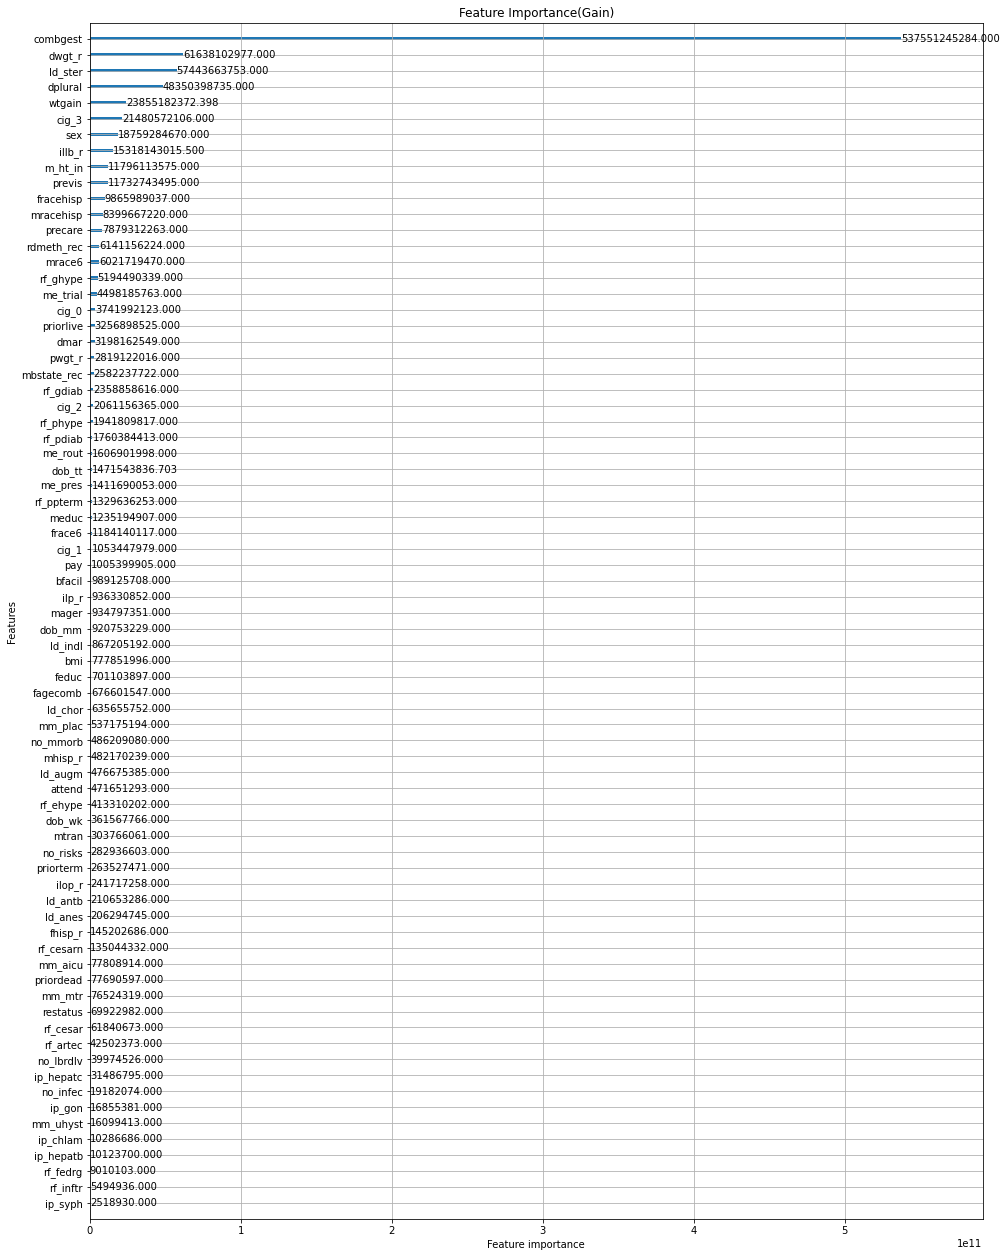

In [72]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_importance(m_lgb, importance_type='gain', ax= ax, title='Feature Importance(Gain)')
fig.savefig('FeatureImportanceGain', bbox_inches = 'tight', pad_inches=0.5)

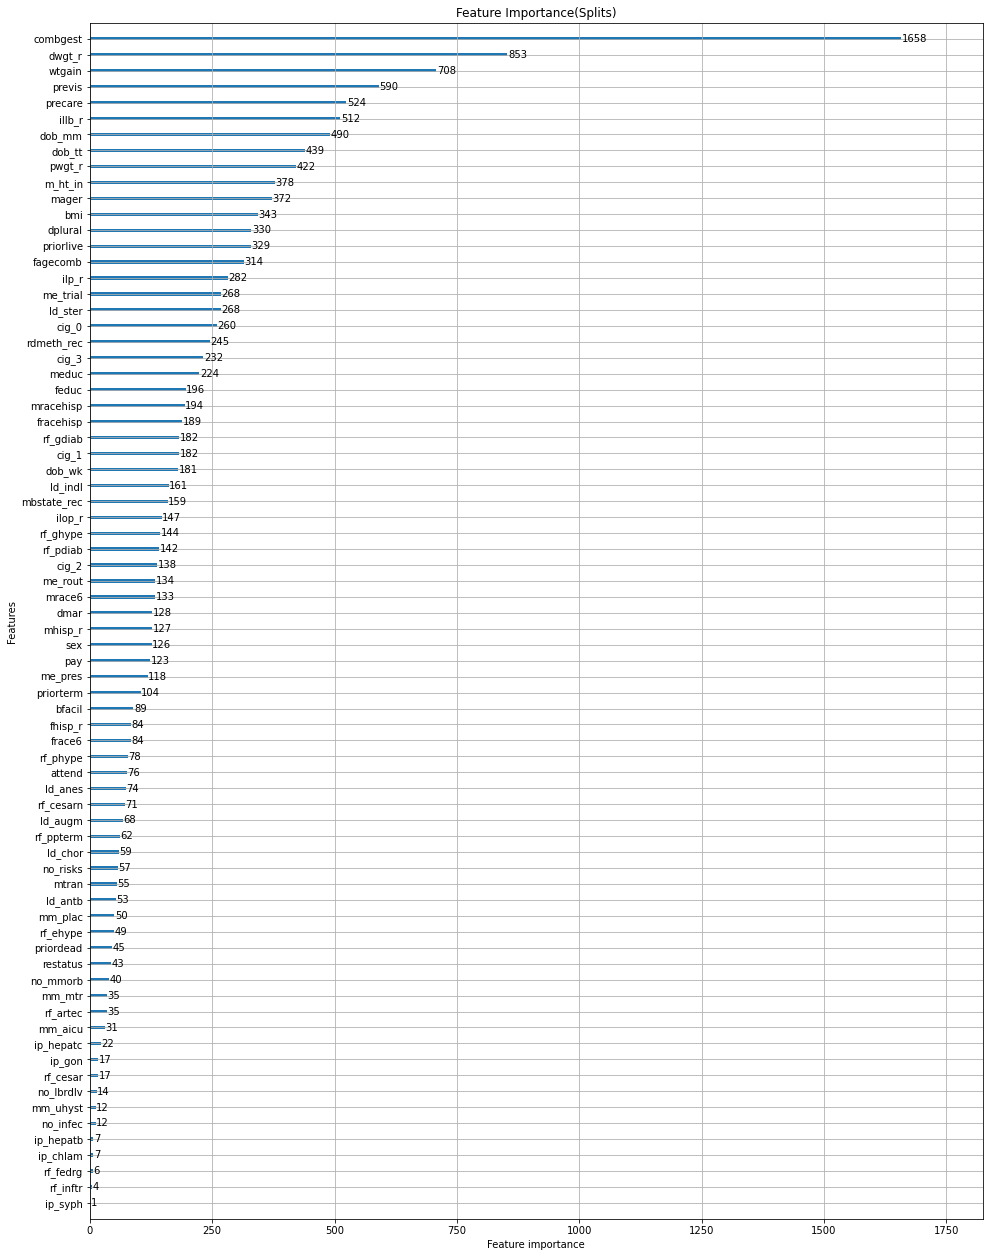

In [73]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_importance(m_lgb, importance_type='split',title='Feature Importance(Splits)', ax= ax)
fig.savefig('FeatureImportanceSplits', bbox_inches = 'tight', pad_inches=0.5)

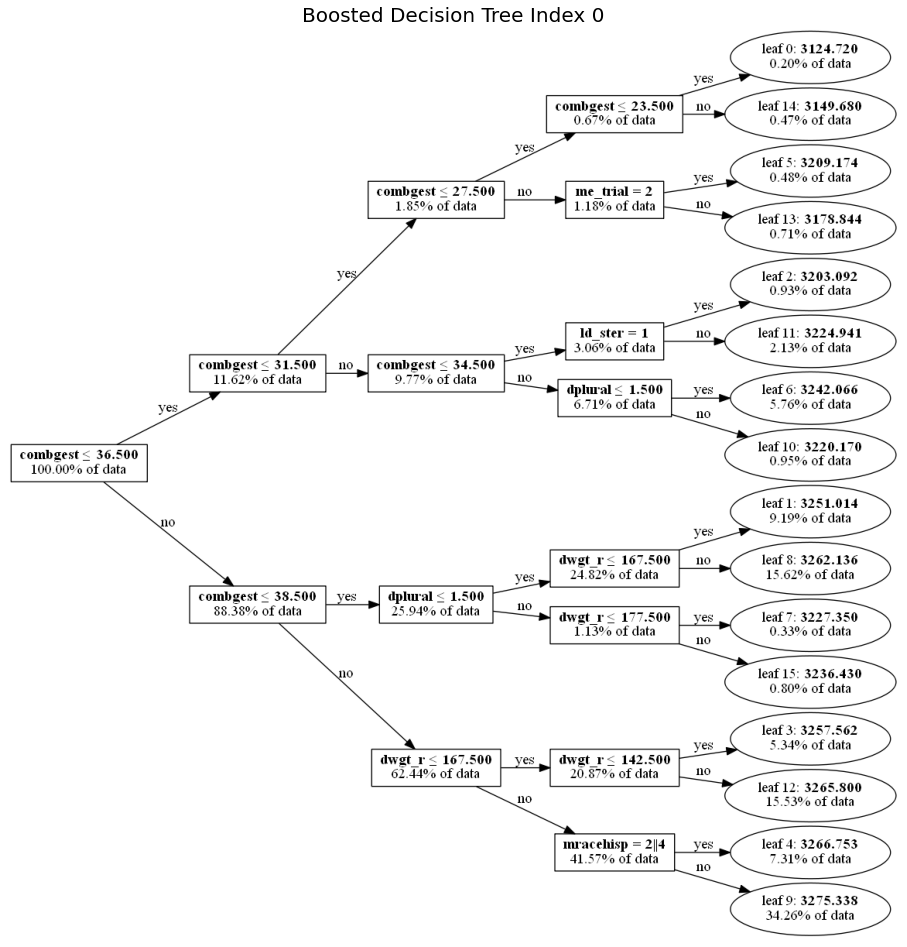

In [79]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_tree(m_lgb, show_info='data_percentage', ax= ax, tree_index=0)
ax.set_title('Boosted Decision Tree Index 0', fontsize=20)
fig.savefig('gbdt0', bbox_inches = 'tight', pad_inches=0.5);

Text(0.5, 1.0, 'Boosted Decision Tree Index 1')

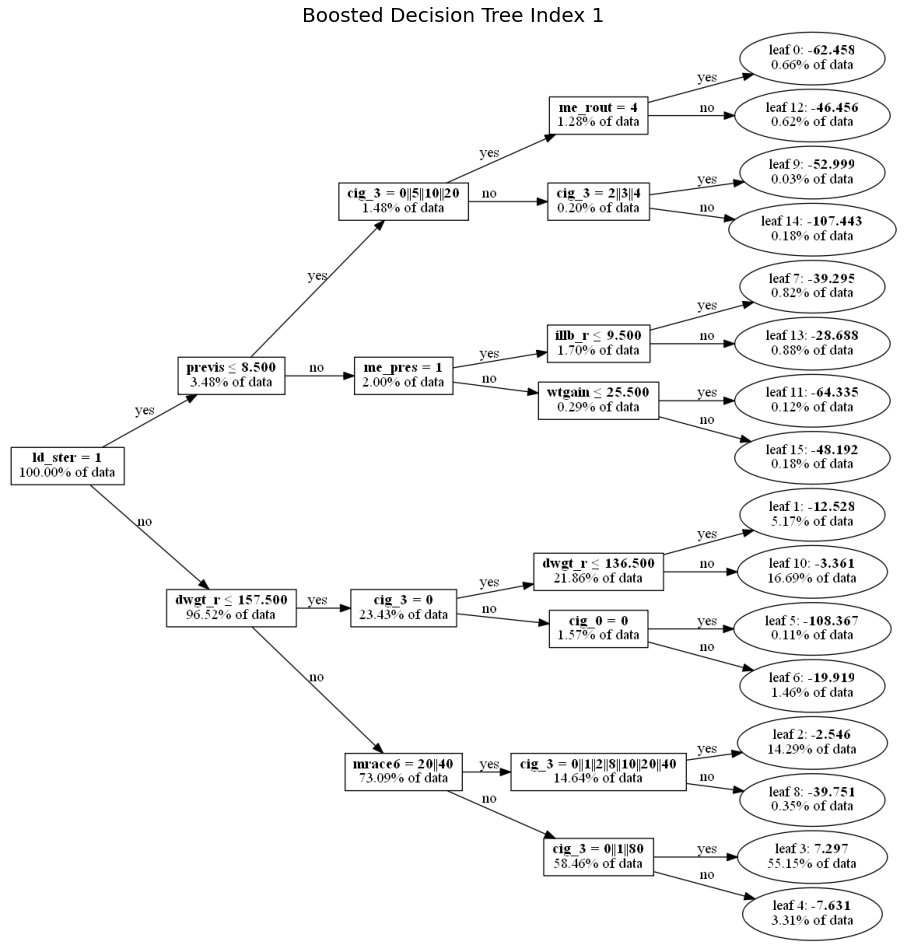

In [75]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_tree(m_lgb, show_info='data_percentage', ax= ax, tree_index=1)
ax.set_title('Boosted Decision Tree Index 1', fontsize=20)

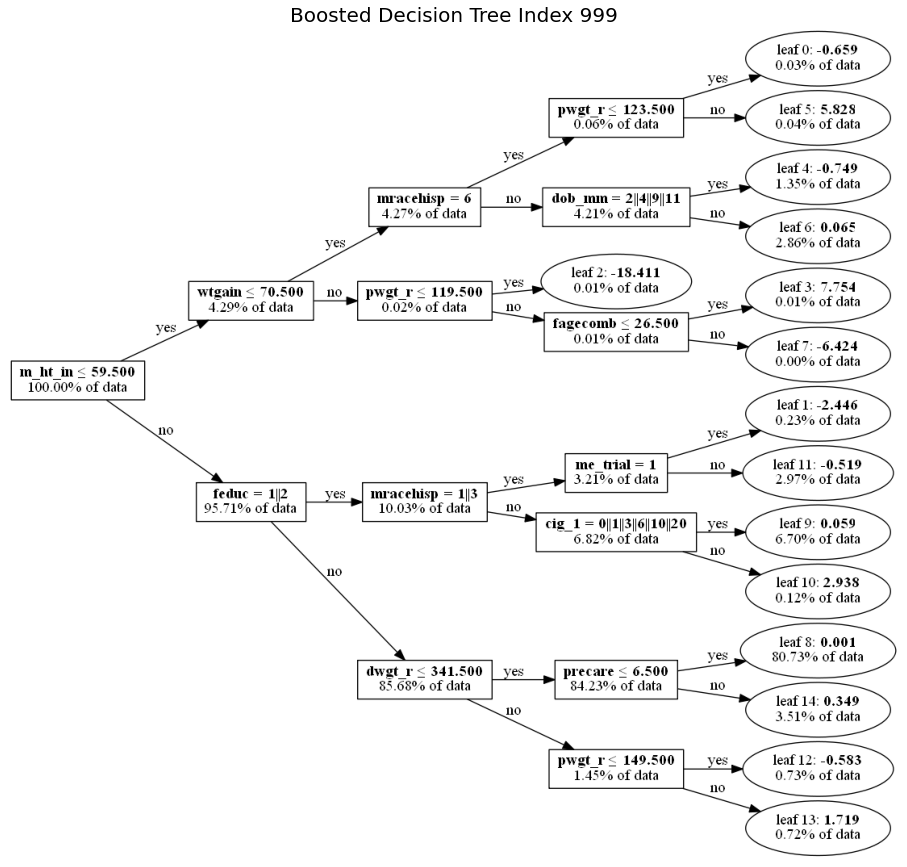

In [80]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_tree(m_lgb, show_info='data_percentage', ax= ax, tree_index=999)
ax.set_title('Boosted Decision Tree Index 999', fontsize=20)
fig.savefig('gbdt999', bbox_inches = 'tight', pad_inches=0.5)

In [37]:
_lgb_test_pred = m_lgb.predict(X_test)

In [38]:
np.sqrt(mean_squared_error(y_test, _lgb_test_pred))

408.481214633894

In [29]:
continuous_columns = ['dob_tt', 'mager', 'fagecomb', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'm_ht_in', 'bmi', 'pwgt_r','dwgt_r', 'wtgain', 'dplural', 'combgest', 
#                       'oegest_comb'
                     ]
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [30]:

scaler = StandardScaler()
_X_train_cont = scaler.fit_transform(X_train[continuous_columns])
_X_train_cont_df = pd.DataFrame(data = _X_train_cont,
                         columns = continuous_columns)

_X_test_cont = scaler.transform(X_test[continuous_columns])
_X_test_cont_df = pd.DataFrame(data = _X_test_cont,
                         columns = continuous_columns)

In [34]:

scaler = StandardScaler()
_X_train_scaled = scaler.fit_transform(X_train)
_X_train_scaled_df = pd.DataFrame(data = _X_train_scaled,
                         columns = X_train.columns,
                                 index= X_train.index)

_X_test_scaled = scaler.transform(X_test)
_X_test_scaled_df = pd.DataFrame(data = _X_test_scaled,
                         columns = X_test.columns,
                              index= X_test.index)

In [35]:
_X_train_scaled_df

,dob_mm,dob_tt,dob_wk,bfacil,mager,mbstate_rec,restatus,mrace6,mhisp_r,mracehisp,dmar,meduc,fagecomb,frace6,fhisp_r,fracehisp,feduc,priorlive,priordead,priorterm,illb_r,ilop_r,ilp_r,precare,previs,cig_0,cig_1,cig_2,cig_3,m_ht_in,f_m_ht,bmi,pwgt_r,dwgt_r,wtgain,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,rf_cesarn,no_risks,ip_gon,ip_syph,ip_chlam,ip_hepatb,ip_hepatc,no_infec,ob_ecvs,ob_ecvf,ld_indl,ld_augm,ld_ster,ld_antb,ld_chor,ld_anes,no_lbrdlv,me_pres,me_rout,me_trial,rdmeth_rec,mm_mtr,mm_plac,mm_rupt,mm_uhyst,mm_aicu,no_mmorb,attend,mtran,pay,dplural,sex,combgest
76247,-0.164287,-1.283332,1.585320,-0.111479,-0.345449,-0.54611,-0.620748,-0.467747,0.363154,1.634415,NaN,0.948743,0.321020,-0.462582,0.366007,1.19103,-0.143247,-0.106728,-0.083253,-0.48036,1.720961,-0.334692,1.923225,-0.593365,-0.548641,-0.234003,-0.200517,-0.182969,-0.173265,-1.810353,0.051191,-0.069749,-0.502126,-0.804155,-0.824345,-0.097394,3.750875,-0.145306,-0.278214,-0.050431,-0.191171,-0.140657,0.129449,0.128161,-0.430465,-0.376916,-1.482691,-0.056324,-0.033055,-0.136356,-0.046358,-0.069256,0.167274,-0.039686,-0.037406,-0.608269,-0.522902,-0.189165,-0.581373,-0.127511,0.576212,-0.429273,-0.213256,-0.724450,0.651814,-0.684490,-0.064069,-0.091417,-0.017191,-0.021586,-0.04052,0.118233,-0.437098,-0.070977,0.177392,-0.183546,-1.021941,0.171439
161921,-1.041666,-0.134844,1.585320,-0.111479,-1.034211,-0.54611,-0.620748,-0.467747,1.954812,1.634415,1.223970,-1.354443,0.614130,NaN,1.959113,1.19103,-0.714413,0.661981,-0.083253,-0.48036,-0.003880,-0.334692,0.057538,-1.907598,-2.701151,-0.234003,-0.200517,-0.182969,-0.173265,-1.103036,0.051191,-0.156794,-0.406741,-0.345228,0.165567,-0.097394,-0.266604,-0.145306,-0.278214,-0.050431,-0.191171,-0.140657,0.129449,0.128161,-0.430465,-0.376916,0.674449,NaN,NaN,NaN,NaN,NaN,NaN,-0.039686,-0.037406,-0.608269,-0.522902,-0.189165,1.720066,-0.127511,0.576212,-0.429273,3.551664,1.423836,-0.530808,1.036565,-0.064069,-0.091417,-0.017191,-0.021586,-0.04052,0.118233,-0.437098,-0.070977,5.421580,-0.183546,-1.021941,-2.279481
256808,1.005553,-0.122189,-1.653753,-0.111479,-1.378592,-0.54611,-0.620748,0.419609,-0.432675,-0.359251,1.223970,-0.778647,NaN,NaN,NaN,1.53517,NaN,-0.875437,-0.083253,-0.48036,-0.787898,-0.334692,-0.790501,NaN,NaN,-0.234003,-0.200517,-0.182969,-0.173265,-0.749377,0.051191,-0.441668,-0.764437,-0.731693,0.099572,-0.097394,-0.266604,-0.145306,-0.278214,-0.050431,-0.191171,-0.140657,0.129449,0.128161,-0.430465,-0.376916,0.674449,-0.056324,-0.033055,-0.136356,-0.046358,-0.069256,0.167274,-0.039686,-0.037406,1.644010,-0.522902,-0.189165,1.720066,-0.127511,0.576212,-0.429273,-0.213256,-0.724450,0.651814,-0.684490,-0.064069,-0.091417,-0.017191,-0.021586,-0.04052,0.118233,-0.437098,-0.070977,-0.696640,-0.183546,0.978530,0.171439
8279,0.128173,-0.009871,-1.113907,-0.111479,1.032074,-0.54611,-0.620748,-0.467747,-0.432675,-0.757984,1.223970,-0.202850,NaN,NaN,NaN,1.53517,NaN,-0.875437,-0.083253,-0.48036,-0.787898,-0.334692,-0.790501,0.063752,0.168862,2.929532,1.253662,1.570100,1.707254,-0.749377,0.051191,-0.441668,-0.764437,-1.045696,-0.758351,-0.097394,-0.266604,-0.145306,-0.278214,-0.050431,-0.191171,-0.140657,0.129449,0.128161,-0.430465,-0.376916,0.674449,-0.056324,-0.033055,-0.136356,-0.046358,-0.069256,0.167274,-0.039686,-0.037406,-0.608269,-0.522902,-0.189165,1.720066,-0.127511,0.576212,-0.429273,3.551664,1.423836,-1.713430,1.036565,-0.064069,-0.091417,-0.017191,-0.021586,-0.04052,0.118233,-0.437098,-0.070977,0.177392,-0.183546,-1.021941,0.171439
277868,1.298012,-0.304112,1.045474,-0.111479,-0.173259,-0.54611,-0.620748,-0.467747,-0.432675,-0.757984,1.223970,-1.354443,-0.558310,0.444654,-0.430546,-0.52967,-0.714413,-0.106728,-0.083253,-0.48036,2.008435,-0.334692,2.234173,0.720868,-0.070306,6.093067,4.162019,5.076239,11.109849,-0.042060,0.051191,-0.813587,-1.217518,-1.214774,0.033578,-0.097394,-0.266604,-0.145306,-0.278214,-0.050431,-0.191171,-0.140657,0.129449,0.128161,-0.43046

In [24]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=5)
KNN_impute_X = imputer.fit_transform(_X_train_scaled_df)

In [ ]:
KNN_impute_X

In [43]:
continuous_columns = ['dob_tt', 'mager', 'fagecomb', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'm_ht_in', 'bmi', 'pwgt_r','dwgt_r', 'wtgain', 'dplural', 'combgest', 
#                       'oegest_comb'
                     ]
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [44]:
X[continuous_columns]

,dob_tt,mager,fagecomb,illb_r,ilop_r,ilp_r,precare,previs,m_ht_in,bmi,pwgt_r,dwgt_r,wtgain,dplural,combgest
0,1000.0,38,41,19.0,34.0,19.0,2.0,14.0,66.0,23.9,148.0,182.0,34.0,1,41.0
1,2145.0,35,35,138.0,0.0,138.0,3.0,10.0,63.0,25.7,145.0,193.0,48.0,1,40.0
2,613.0,25,27,0.0,0.0,0.0,4.0,8.0,60.0,32.2,165.0,183.0,18.0,1,40.0
3,1534.0,21,22,0.0,0.0,0.0,2.0,13.0,66.0,29.0,180.0,220.0,40.0,1,31.0
4,917.0,35,39,34.0,NaN,NaN,3.0,10.0,65.0,24.1,145.0,189.0,44.0,1,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,1004.0,22,22,23.0,0.0,23.0,2.0,14.0,62.0,26.5,145.0,184.0,39.0,1,40.0
749996,2106.0,25,30,30.0,NaN,NaN,2.0,13.0,62.0,19.2,105.0,120.0,15.0,1,39.0
749997,1357.0,17,18,0.0,0.0,0.0,2.0,6.0,64.0,36.0,210.0,257.0,47.0,1,40.0
749998,2347.0,23,31,43.0,NaN,NaN,2.0,13.0,65.0,32.4,195.0,205.0,10.0,1,40.0


In [47]:
X[categorical_columns] = X[categorical_columns].apply(lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]),
                                                                              index=series[series.notnull()].index))

In [ ]:
imputer = KNNImputer(n_neighbors=15)
imputer.fit_transform(X)

In [67]:
# scaler = StandardScaler()
# _X_cont = scaler.fit_transform(X[continuous_columns])
# _X_cont_df = pd.DataFrame(data = _X_cont,
#                                 index= X.index,
#                          columns = continuous_columns)



In [68]:
ohe = OneHotEncoder()
_X_ohe = ohe.fit_transform(X[categorical_columns]).toarray()
_X_ohe_df = pd.DataFrame(data = _X_ohe,
                         index = X.index,
                        columns = ohe.get_feature_names(categorical_columns))


_X_merged = X[continuous_columns].merge(_X_ohe_df, left_index=True, right_index=True)
_X_merged.shape

(659744, 275)

In [69]:
# poly_2 = PolynomialFeatures(degree=2, include_bias=False)
# poly2_data = poly_2.fit_transform(_X_merged)
# poly2_columns = poly_2.get_feature_names(_X_merged.columns)
# df_poly2 = pd.DataFrame(poly2_data, columns = poly2_columns)
# df_poly2

In [70]:
_X_merged

,dob_tt,mager,fagecomb,illb_r,ilop_r,ilp_r,precare,previs,m_ht_in,bmi,pwgt_r,dwgt_r,wtgain,dplural,combgest,dob_mm_1,dob_mm_2,dob_mm_3,dob_mm_4,dob_mm_5,dob_mm_6,dob_mm_7,dob_mm_8,dob_mm_9,dob_mm_10,dob_mm_11,dob_mm_12,dob_wk_1,dob_wk_2,dob_wk_3,dob_wk_4,dob_wk_5,dob_wk_6,dob_wk_7,bfacil_BirthCenter,bfacil_Clinic,bfacil_Home,bfacil_Hospital,bfacil_Other,bfacil_Unknown,mbstate_rec_BornInUSA,mbstate_rec_BornOutUSA,mbstate_rec_Unknown,restatus_Foreign,restatus_InterstateNonresident,restatus_IntrastateNonresident,restatus_Resident,mrace6_AIAN,mrace6_Asian,mrace6_Black,mrace6_Multi,mrace6_NHOPI,mrace6_White,mhisp_r_CentralSouthAmerican,mhisp_r_Cuban,mhisp_r_Mexican,mhisp_r_Non-Hispanic,mhisp_r_OtherHispanic,mhisp_r_Puerto Rican,mhisp_r_Unknown,mracehisp_Hispanic,mracehisp_NonHispanicAIAN,mracehisp_NonHispanicAsian,mracehisp_NonHispanicBlack,mracehisp_NonHispanicMulti,mracehisp_NonHispanicNHOPI,mracehisp_NonHispanicWhite,mracehisp_Unknown,dmar_Married,dmar_Unmarried,meduc_AssociateDegree,meduc_BachelorDegree,meduc_CollegeIncomplete,meduc_Doctorate,meduc_HighSchoolComplete,meduc_HighSchoolIncomplete,meduc_JuniorHighIncomplete,meduc_MasterDegree,meduc_Unknown,frace6_AIAN,frace6_Asian,frace6_Black,frace6_Multi,frace6_NHOPI,frace6_Unknown,frace6_White,fhisp_r_CentralSouthAmerican,fhisp_r_Cuban,fhisp_r_Dominican,fhisp_r_Mexican,fhisp_r_NonHispanic,fhisp_r_PuertoRican,fhisp_r_Unknown,fracehisp_Hispanic,fracehisp_NonHispanicAIAN,fracehisp_NonHispanicAsian,fracehisp_NonHispanicBlack,fracehisp_NonHispanicMulti,fracehisp_NonHispanicNHOPI,fracehisp_NonHispanicWhite,fracehisp_Unknown,feduc_AssociateDegree,feduc_BachelorDegree,feduc_CollegeIncomplete,feduc_Doctorate,feduc_HighSchoolComplete,feduc_HighSchoolIncomplete,feduc_JuniorHighIncomplete,feduc_MasterDegree,feduc_Unknown,priorlive_Multi,priorlive_None,priorlive_One,priorlive_Unknown,priordead_Multi,priordead_None,priordead_One,priordead_Unknown,priorterm_Multi,priorterm_None,priorterm_One,priorterm_Unknown,cig_0_None,cig_0_Unknown,cig_0_Yes,cig_1_None,cig_1_Unknown,cig_1_Yes,cig_2_None,cig_2_Unknown,cig_2_Yes,cig_3_None,cig_3_Unknown,cig_3_Yes,f_m_ht_0,f_m_ht_1,rf_pdiab_N,rf_pdiab_U,rf_pdiab_Y,rf_gdiab_N,rf_gdiab_U,rf_gdiab_Y,rf_phype_N,rf_phype_U,rf_phype_Y,rf_ghype_N,rf_ghype_U,rf_ghype_Y,rf_ehype_N,rf_ehype_U,rf_ehype_Y,rf_ppterm_N,rf_ppterm_U,rf_ppterm_Y,rf_inftr_N,rf_inftr_U,rf_inftr_Y,rf_fedrg_N,rf_fedrg_U,rf_fedrg_X,rf_fedrg_Y,rf_artec_N,rf_artec_U,rf_artec_X,rf_artec_Y,rf_cesar_N,rf_cesar_U,rf_cesar_Y,rf_cesarn_Multi,rf_cesarn_None,rf_cesarn_One,rf_cesarn_Unknown,no_risks_N,no_risks_U,no_risks_Y,ip_gon_N,ip_gon_U,ip_gon_Y,ip_syph_N,ip_syph_U,ip_syph_Y,ip_chlam_N,ip_chlam_U,ip_chlam_Y,ip_hepatb_N,ip_hepatb_U,ip_hepatb_Y,ip_hepatc_N,ip_hepatc_U,ip_hepatc_Y,no_infec_N,no_infec_U,no_infec_Y,ob_ecvs_N,ob_ecvs_U,ob_ecvs_Y,ob_ecvf_N,ob_ecvf_U,ob_ecvf_Y,ld_indl_N,ld_indl_U,ld_indl_Y,ld_augm_N,ld_augm_U,ld_augm_Y,ld_ster_N,ld_ster_U,ld_ster_Y,ld_antb_N,ld_antb_U,ld_antb_Y,ld_chor_N,ld_chor_U,ld_chor_Y,ld_anes_N,ld_anes_U,ld_anes_Y,no_lbrdlv_N,no_lbrdlv_U,no_lbrdlv_Y,me_pres_Breech,me_pres_Cephalic,me_pres_Other,me_pres_Unknown,me_rout_Cesarean,me_rout_Forceps,me_rout_Spontaneous,me_rout_Unknown,me_rout_Vacuum,me_trial_N,me_trial_U,me_trial_X,me_trial_Y,rdmeth_rec_PrimaryCSection,rdmeth_rec_RepeatCSection,rdmeth_rec_Unknown,rdmeth_rec_Vaginal,rdmeth_rec_VaginalAfterCSection,mm_mtr_N,mm_mtr_U,mm_mtr_Y,mm_plac_N,mm_plac_U,mm_plac_Y,mm_rupt_N,mm_rupt_U,mm_rupt_Y,mm_uhyst_N,mm_uhyst_U,mm_uhyst_Y,mm_aicu_N,mm_aicu_U,mm_aicu_Y,no_mmorb_No,no_mmorb_Unknown,no_mmorb_Yes,attend_DoctorMedicine,attend_DoctorOsteopathy,attend_NurseMidwife,attend_Other,attend_OtherMidwife,attend_Unknown,mtran_N,mtran_U,mtran_Y,pay_IndianHealthService,pay_Medicaid,pay_Other,pay_OtherGovernment,pay_PrivateInsurance,pay_SelfPay,pay_Tricare,pay_Unknown,sex_F,sex_M
1,1000,38,41,19,34,19,2,14,66,23.9,148,182,34,1,41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0

In [71]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

# ols = LinearRegression()
# selector = RFECV(estimator= ols, step = 1, cv=5, scoring ='neg_mean_squared_error')
# selector = selector.fit(_X_merged, y)

In [108]:
selector = SelectKBest(f_regression, k=30)
selector.fit(_X_merged, y)

SelectKBest(k=30, score_func=<function f_regression at 0x000000001217B4C8>)

In [109]:
selected_columns = _X_merged.columns[selector.get_support()]

In [110]:
lm_kbest = LinearRegression()
lm_kbest = lm_kbest.fit(_X_merged[selected_columns], y)

In [111]:
print(lm_kbest.intercept_)
lm_kbest.score(_X_merged[selected_columns], y)

-1544.0562605481973


0.43279600193633416

In [112]:
coef_df = pd.DataFrame()
coef_df['variables'] = selected_columns
coef_df['values'] = lm_kbest.coef_
coef_df.sort_values(by='values')

,variables,values
5,dplural,-538.574534
22,ld_ster_Y,-391.765322
18,cig_3_Unknown,-292.732019
27,mtran_Y,-264.496841
9,mracehisp_NonHispanicBlack,-115.890299
20,rf_ghype_Y,-104.568796
23,me_pres_Breech,-93.680897
26,mtran_N,-60.108034
28,sex_F,-59.815841
10,mracehisp_NonHispanicWhite,-26.619169


In [153]:
_X_merged

,dob_tt,mager,fagecomb,illb_r,ilop_r,ilp_r,precare,previs,m_ht_in,bmi,pwgt_r,dwgt_r,wtgain,dplural,combgest,oegest_comb,dob_mm_1,dob_mm_2,dob_mm_3,dob_mm_4,dob_mm_5,dob_mm_6,dob_mm_7,dob_mm_8,dob_mm_9,dob_mm_10,dob_mm_11,dob_mm_12,dob_wk_1,dob_wk_2,dob_wk_3,dob_wk_4,dob_wk_5,dob_wk_6,dob_wk_7,bfacil_Unknown,mbstate_rec_Unknown,restatus_Foreign,mrace6_Multi,mhisp_r_Unknown,mracehisp_Unknown,dmar_Unmarried,meduc_Unknown,frace6_Unknown,fhisp_r_Unknown,fracehisp_Unknown,feduc_Unknown,priorlive_Multi,priordead_Multi,priorterm_Multi,cig_0_Yes,cig_1_Yes,cig_2_Yes,cig_3_Yes,f_m_ht_0,f_m_ht_1,rf_pdiab_N,rf_pdiab_U,rf_pdiab_Y,rf_gdiab_N,rf_gdiab_U,rf_gdiab_Y,rf_phype_N,rf_phype_U,rf_phype_Y,rf_ghype_N,rf_ghype_U,rf_ghype_Y,rf_ehype_N,rf_ehype_U,rf_ehype_Y,rf_ppterm_N,rf_ppterm_U,rf_ppterm_Y,rf_inftr_N,rf_inftr_U,rf_inftr_Y,rf_fedrg_N,rf_fedrg_U,rf_fedrg_X,rf_fedrg_Y,rf_artec_N,rf_artec_U,rf_artec_X,rf_artec_Y,rf_cesar_N,rf_cesar_U,rf_cesar_Y,rf_cesarn_Multi,no_risks_U,ip_gon_N,ip_gon_U,ip_gon_Y,ip_syph_N,ip_syph_U,ip_syph_Y,ip_chlam_N,ip_chlam_U,ip_chlam_Y,ip_hepatb_N,ip_hepatb_U,ip_hepatb_Y,ip_hepatc_N,ip_hepatc_U,ip_hepatc_Y,no_infec_U,ob_ecvs_N,ob_ecvs_U,ob_ecvs_Y,ob_ecvf_N,ob_ecvf_U,ob_ecvf_Y,ld_indl_N,ld_indl_U,ld_indl_Y,ld_augm_N,ld_augm_U,ld_augm_Y,ld_ster_N,ld_ster_U,ld_ster_Y,ld_antb_N,ld_antb_U,ld_antb_Y,ld_chor_N,ld_chor_U,ld_chor_Y,ld_anes_N,ld_anes_U,ld_anes_Y,no_lbrdlv_U,me_pres_Unknown,me_rout_Unknown,me_trial_N,me_trial_U,me_trial_X,me_trial_Y,rdmeth_rec_Unknown,mm_mtr_N,mm_mtr_U,mm_mtr_Y,mm_plac_N,mm_plac_U,mm_plac_Y,mm_rupt_N,mm_rupt_U,mm_rupt_Y,mm_uhyst_N,mm_uhyst_U,mm_uhyst_Y,mm_aicu_N,mm_aicu_U,mm_aicu_Y,no_mmorb_Unknown,attend_DoctorMedicine,attend_DoctorOsteopathy,attend_NurseMidwife,attend_Other,attend_OtherMidwife,attend_Unknown,mtran_N,mtran_U,mtran_Y,pay_IndianHealthService,pay_Medicaid,pay_Other,pay_OtherGovernment,pay_PrivateInsurance,pay_SelfPay,pay_Tricare,pay_Unknown,sex_F,sex_M
0,1227,30,31,16,33,16,3,8,66,30.7,190,231,41,1,38,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1704,35,35,180,0,180,3,9,63,33.3,188,185,0,1,39,39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,938,23,26,43,0,43,5,6,64,23.7,138,138,0,1,31,39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,28,26,28,39,0,39,2,13,67

In [33]:
from sklearn.linear_model import LassoCV

In [34]:
lassoCV_model = LassoCV(cv=5, random_state=42, verbose=1)
lassoCV_model.fit(_X_merged, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.9s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=1)

In [35]:
lassoCV_model.score(_X_merged, y)

0.4575955703721287

In [36]:
coef_df = pd.DataFrame()
coef_df['features'] = _X_merged.columns
coef_df['values'] = lassoCV_model.coef_

In [37]:
coef_df.sort_values(by = 'values')

,features,values
132,cig_3_Unknown,-5.322999e+02
207,ld_ster_Y,-2.396552e+02
111,priorlive_None,-1.369377e+02
273,sex_F,-1.166576e+02
264,mtran_Y,-1.131762e+02
13,dplural,-1.088902e+02
136,rf_pdiab_N,-1.072654e+02
63,mracehisp_NonHispanicBlack,-1.049762e+02
150,rf_ehype_Y,-9.181363e+01
144,rf_phype_Y,-8.615725e+01


In [38]:
lassoCV_model.intercept_

3297.8450038923843

In [47]:
y_test_lasso = lasso_cv.predict(X_test[_new_columns])
np.sqrt(metrics.mean_squared_error(y_test, y_test_lasso))

458.61005898777387

In [48]:
lasso_cv.score(X_test[_new_columns],y_test)

0.37668578548315934

# Key Insights